
# 作業: 
    
    (1)以, Adam, 為例, 調整 batch_size, epoch , 觀察accurancy, loss 的變化
    
    (2)以同一模型, 分別驗證 SGD, Adam, Rmsprop 的 accurancy

In [1]:
import keras
#from keras.datasets import cifar10
from keras.datasets import mnist 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy 

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

Using TensorFlow backend.


In [2]:
class OptModel:
    def __init__(self):
        # 第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
        self.model = Sequential()

        # 第二步：構建網絡層
        self.model.add(Dense( 500,input_shape=(784,))) # 輸入層，28*28=784   
        self.model.add(Activation('relu')) # 激活函數是relu   

        self.model.add(Dense( 500)) # 隱藏層節點500個   
        self.model.add(Activation('relu'))  

        self.model.add(Dense( 500)) # 隱藏層節點500個   
        self.model.add(Activation('relu'))  

        self.model.add(Dense( 500)) # 隱藏層節點500個   
        self.model.add(Activation('relu'))  

        self.model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
        self.model.add(Activation('softmax')) # 最後一層用softmax作為激活函數
    
        # 模型建立完成後，統計參數總量
        print("Total Parameters：%d" % self.model.count_params())
        
        # 輸出模型摘要資訊
        self.model.summary()
    def comp(self, method, loss = 'binary_crossentropy', metrics = ['accuracy'], **kwargs):
        if (method == 'adam'):
            optimizer = optimizers.Adam(lr=kwargs['lr'], beta_1=kwargs['beta_1'], beta_2=kwargs['beta_2'], epsilon=kwargs['epsilon'], \
                                        decay=kwargs['decay'], amsgrad=kwargs['amsgrad'])
        elif (method == 'sgd'):
            optimizer = optimizers.SGD(lr = kwargs['lr'], momentum = kwargs['momentum'], decay = kwargs['decay'], \
                                       nesterov = kwargs['nesterov'])
        elif (method == 'RMSProp'):
            optimizer = optimizers.RMSprop(lr = kwargs['lr'], rho = kwargs['rho'], epsilon = kwargs['epsilon'], \
                                           decay = kwargs['decay'])
        
        self.model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
            
        # 第四步：資料分割
        # 使用Keras自帶的mnist工具讀取數據（第一次需要聯網）
        (self.X_train, self.y_train), (self.X_test, self.y_test) = mnist.load_data() 

        # 由於mist的輸入數據維度是(num, 28 , 28)，這裡需要把後面的維度直接拼起來變成784維   
        self.X_train = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1] * self.X_train.shape[2 ])
        self.X_test = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1] * self.X_test.shape[2 ])  
        self.Y_train = (numpy.arange(10) == self.y_train[:, None]).astype(int)
        self.Y_test = (numpy.arange(10) == self.y_test[:, None]).astype(int)
    def fit(self, batch_size, epochs):
        # 第五步：訓練, 修正 model 參數
        #Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
        sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


        self.history = self.model.fit(self.X_train,self.Y_train,batch_size = batch_size, epochs=epochs, shuffle=True,verbose=2,validation_split=0.3)
    def output(self):
        # 第六步：輸出
        print ( " test set " )
        scores = self.model.evaluate(self.X_test,self.Y_test,batch_size=200,verbose= 0)
        print ( "" )
        #print ( " The test loss is %f " % scores)
        print ( " The test loss is %f ", scores)
        self.result = self.model.predict(self.X_test,batch_size=200,verbose= 0)

        self.result_max = numpy.argmax(self.result, axis = 1 )
        self.test_max = numpy.argmax(self.Y_test, axis = 1 )

        self.result_bool = numpy.equal(self.result_max, self.test_max)
        self.true_num = numpy.sum(self.result_bool)
        print ( "" )
        print ( " The accuracy of the model is %f " % (self.true_num/len(self.result_bool)))
    def picture(self):
        # Plot training & validation accuracy values
        plt.plot(self.history.history['acc'])
        plt.plot(self.history.history['val_acc'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        # Plot training & validation loss values
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

#### Adam - Arguments
- lr: float >= 0. 学习率。
- beta_1: float, 0 < beta < 1. 通常接近于 1。
- beta_2: float, 0 < beta < 1. 通常接近于 1。
- epsilon: float >= 0. 模糊因子. 若为 None, 默认为 K.epsilon()。
- decay: float >= 0. 每次参数更新后学习率衰减值。
- amsgrad: boolean. 是否应用此算法的 AMSGrad 变种，来自论文 "On the Convergence of Adam and Beyond"。

#### SGD(隨機梯度下降) - Arguments
- lr: float >= 0. 学习率。
- momentum: float >= 0. 参数，用于加速 SGD 在相关方向上前进，并抑制震荡。
- decay: float >= 0. 每次参数更新后学习率衰减值。
- nesterov: boolean. 是否使用 Nesterov 动量。

#### RMSprop- Arguments
- lr: float >= 0. 学习率。
- rho: float >= 0. RMSProp梯度平方的移动均值的衰减率.
- epsilon: float >= 0. 模糊因子. 若为 None, 默认为 K.epsilon()。
- decay: float >= 0. 每次参数更新后学习率衰减值。

#### fit 的訓練
- batch_size：對總的樣本數進行分組，每組包含的樣本數量
- epochs ：訓練次數

Total Parameters：1149010
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_2 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_3 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)           

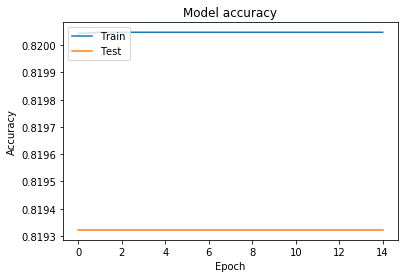

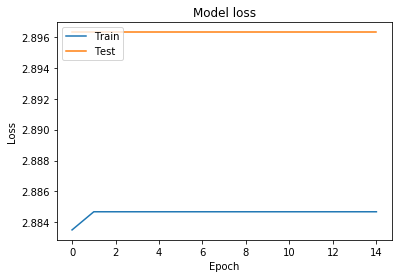

In [3]:
# 作業 1 ==> 以 Adam, 為例, 調整 batch_size, epoch , 觀察accurancy, loss 的變化
model_adam = OptModel()
model_adam.comp(method = 'adam', lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_adam.fit(batch_size = 88, epochs = 15)
model_adam.output()
model_adam.picture()

Total Parameters：1149010
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 500)               392500    
_________________________________________________________________
activation_6 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_7 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_8 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)           

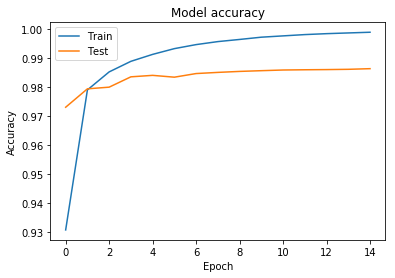

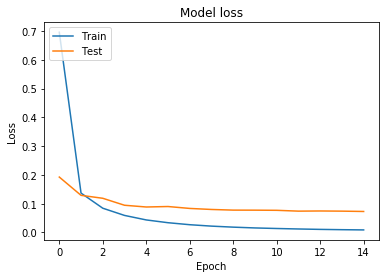

In [4]:
# 作業 2 ==> 以同一模型, 分別驗證 SGD, Adam, Rmsprop 的 accurancy
# ==========> SGD
model_adam = OptModel()
model_adam.comp(method = 'sgd', lr = 0.002, momentum = 0.0, decay = 0.0, nesterov = False)
model_adam.fit(batch_size = 88, epochs = 15)
model_adam.output()
model_adam.picture()

Total Parameters：1149010
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 500)               392500    
_________________________________________________________________
activation_11 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 500)               250500    
_________________________________________________________________
activation_12 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 500)               250500    
_________________________________________________________________
activation_13 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 500)           

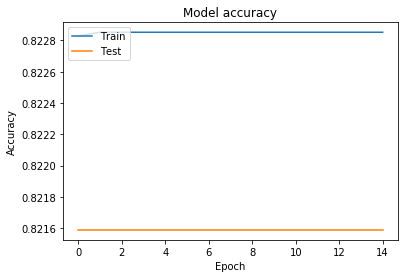

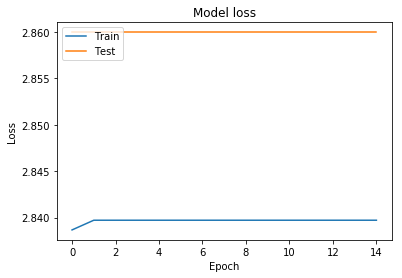

In [5]:
# ==========> Rmsprop
model_adam = OptModel()
model_adam.comp(method = 'RMSProp', lr = 0.002, rho = 0.9, epsilon = None, decay = 0.0)
model_adam.fit(batch_size = 88, epochs = 15)
model_adam.output()
model_adam.picture()